# Air Pollution Time Series Analysis and Forcasting:

--------------------

### Getting the Data:

In [326]:
# import statements:

import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy as sa 
import os
from sqlalchemy import create_engine
import numpy as np

Building a connection with MySQL to access the warehouse and retrieve the data we want.

In [221]:
# building the connection

warehouse_url = f"mysql+pymysql://{os.environ['TEST_DB_USERNAME']}:{os.environ['TEST_DB_PASSWORD']}@{os.environ['TEST_DB_HOSTNAME']}/lung_caner_air_pollution_warehouse"
warehouse_engine = create_engine(warehouse_url)

In [222]:
# testing if the connection is successful and active

try:
    with warehouse_engine.connect() as connection:
        print("Connection to MySQL database successful!")
except Exception as e:
    print(f"Error: {e}")

Connection to MySQL database successful!


now to retrieve the data from the warehouse, the way this is done is by using the connection to execute an sql query then we store the result in a pandas data frame so we can continue with our work as usual:

In [223]:
# retrieving the data
with warehouse_engine.connect() as connection:
    # query to get the data we want
    query = sa.text("SELECT c.country_name, d.date, f.air_quality_index FROM fact_patient_air_information AS f INNER JOIN dim_countries as c ON f.country_code = c.country_code INNER JOIN dim_dates as d ON f.diagnosis_date_id = d.date_id")
    result = connection.execute(query) # executing the query
    table = result.all() # getting all the rows from the result as a list of tuples
    wh_df = pd.DataFrame(table, columns=result.keys()) # turn the rows into a dataframe

wh_df.head() # checking if it worked

country_name     date  air_quality_index
0         Germany  2016-04            49.1060
1  Czech Republic  2023-04            59.7973
2          Greece  2023-12           132.5070
3         Denmark  2018-05            62.1726
4        Slovakia  2021-03           109.3010

In [224]:
len(wh_df.country_name.unique()) # making sure we got all our 27 countries in the dataset

27

### General Look at the data:

let us see how many rows and columns we have:

In [225]:
print(f"We have {wh_df.shape[0]} rows and {wh_df.shape[1]} columns.") # getting the number of rows using .shape that returns a tuple (# rows,# cols)

We have 1677525 rows and 3 columns.


let us look at the columns generally:

In [226]:
wh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677525 entries, 0 to 1677524
Data columns (total 3 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   country_name       1677525 non-null  object 
 1   date               1677525 non-null  object 
 2   air_quality_index  1676941 non-null  float64
dtypes: float64(1), object(2)
memory usage: 38.4+ MB


we need to later on turn our date column into a period so we can properly do the time analysis!

### Data Cleaning:

let us first check if we have any duplicated values:

In [227]:
wh_df.duplicated().sum() # checking for duplicates

1674310

we have alot of duplicated values! we could have avoided this use by using the keyword DISTINCT in our query, at the same time it is an easy fix in pandas by using .drop_duplicates()

In [228]:
wh_df = wh_df.drop_duplicates() # dropping the duplicates
wh_df.duplicated().sum() # chekcing if it worked

0

now, let us check for null values!

In [229]:
wh_df.isna().sum() # checking how many null values we have

country_name         0
date                 0
air_quality_index    1
dtype: int64

we have 1 null value. let us see if we can fix it without dropping it!

In [230]:
wh_df[wh_df['air_quality_index'].isna() == True]

country_name     date  air_quality_index
58      Estonia  2015-03                NaN

To fix this we can get the mean for Estonia in March over the years or the mean over 2015, and check which one makes more sense

In [231]:
wh_df[(wh_df['country_name'] == 'Estonia') & (wh_df['date'].str.find('03') != -1)] # getting all the indexes for Estonia in March

country_name     date  air_quality_index
58         Estonia  2015-03                NaN
687        Estonia  2022-03            34.0500
1642       Estonia  2018-03            32.6789
1644       Estonia  2021-03            20.3287
2037       Estonia  2020-03            26.1193
3895       Estonia  2019-03            17.4114
5027       Estonia  2016-03            34.6660
5158       Estonia  2023-03            15.9533
6700       Estonia  2017-03            28.6431
23314      Estonia  2024-03            46.7695

In [232]:
wh_df[(wh_df['country_name'] == 'Estonia') & (wh_df['date'].str.find('03') != -1)]['air_quality_index'].mean() # getting the index mean for March

28.513355555555556

the result here makes sense!

In [233]:
wh_df[(wh_df['country_name'] == 'Estonia') & (wh_df['date'].str.find('2015') != -1)] # getting the 2015 index values for Estonia

country_name     date  air_quality_index
58        Estonia  2015-03                NaN
125       Estonia  2015-02            33.9208
174       Estonia  2015-11            19.8500
408       Estonia  2015-01            24.5697
610       Estonia  2015-07            23.9523
1168      Estonia  2015-09            24.5071
1197      Estonia  2015-04            23.6851
1272      Estonia  2015-08            30.3356
1693      Estonia  2015-06            30.6394
2358      Estonia  2015-10            30.2523
5817      Estonia  2015-12            28.4060
6626      Estonia  2015-05            25.3606

In [234]:
wh_df[(wh_df['country_name'] == 'Estonia') & (wh_df['date'].str.find('2015') != -1)]['air_quality_index'].mean() # getting the 2015 index mean value

26.861718181818176

both results makes sense and are very close, so I will choose the March mean.

In [256]:
wh_df.loc[wh_df['air_quality_index'].isna() == True]['air_quality_index'] = 28.5134 # replacing the null value with the mean
wh_df.isna().sum() # seeing if it worked

C:\Users\allab\AppData\Local\Temp\ipykernel_19624\3307909204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wh_df.loc[wh_df['air_quality_index'].isna() == True]['air_quality_index'] = 28.5134 # replacing the null value with the mean


country_name         0
date                 0
air_quality_index    1
dtype: int64

now we are done with cleaning the data let us go to the analysis!

### Analysis:

Before we begin our analysis, we need to know what the index numbers imply. 

I will provide a table below that has the index ranges and their implication to use a reference!

| AQI Range | Category        | Description                         |
|-----------|-----------------|-------------------------------------|
| 0-50      | Good            | Air quality is considered satisfactory, and air pollution poses little or no risk. |
| 51-100    | Moderate        | Air quality is acceptable; however, there may be a risk for some pollutants. |
| 101-150    | Unhealthy for Sensitive Groups | Members of sensitive groups may experience health effects. The general public is not likely to be affected. |
| 151-200    | Unhealthy       | Everyone may begin to experience health effects; members of sensitive groups may experience more serious health effects. |
| 201-300    | Very Unhealthy  | Health alert: everyone may experience more serious health effects. |
| 301-500    | Hazardous        | Health warnings of emergency conditions. The entire population is more likely to be affected. |


#### All of Europe:

to begin with, we will do our analysis over europe as a whole!

Our first step will be grouping all the data by the date and getting the mean of the air quality index!

In [236]:
europe = wh_df.groupby('date').agg({'air_quality_index' : 'mean'}).reset_index() # grouping by date
europe

date  air_quality_index
0    2014-06          56.831493
1    2014-07          61.858600
2    2014-08          55.399041
3    2014-09          67.577185
4    2014-10          78.673819
..       ...                ...
116  2024-02          61.259130
117  2024-03          68.389059
118  2024-04          60.678300
119  2024-05          61.133593
120  2024-06          61.849820

[121 rows x 2 columns]

now we will change the date column from string to period so we can better work with it!

In [237]:
europe['date'] = europe['date'].astype('period[M]') # changing the date column to period
europe['date'].dtype # making sure it worked


period[M]

In [238]:
europe = europe.set_index('date') # setting the date column as the df index so we can easily plot the values

let us look at the data as a whole and see what we can hypothesize!

<Axes: xlabel='date'>

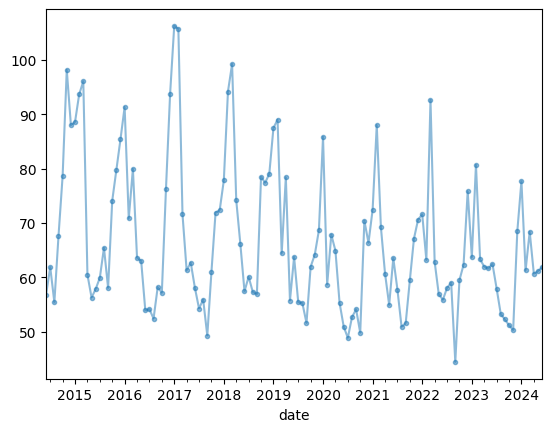

In [239]:
europe['air_quality_index'].plot(marker='.', alpha=0.5, linestyle='-') 

The first thing we can notice is that the Air Pollution Index is mostly between 50 and 100, this implies that the pollution level is moderate and is passable, but may still cause a risk due to the presence of some pollutants in the air!


The second thing we can notice is that the Air Index around 2020 was lower than usual and this can be contributed to the lock down period when people where staying at home so alot of pollutant emissions that were related to day to day life from commuting, etc.. were so much lower which led the air quality in this time to be better.


The third thing is, in 2017 we had the highest Air Index, it even crossed the 100 threshold which means the air was unhealthy for sensitive groups. This might be due to the fact that in 2017 Southern Europe had a lot of wildfires and forest fires. And, a heat wave took place in 2017 which can trap pollutants near the ground and with having reduced wind speeds, these pollutants were not disperesed. Another contributing factor was that there was an increase in wood burning throughout the winter which may have also affected the air quality index.


One final thing we can notice is taht around 2023 we had a great decrease in the air index, however there is nothing that can be contributed to it from the plot.


So, let us further look at how the Air Index varied over the years! 

resampling the data so we can analyze it over the years, rather than year - month

In [240]:
europe_y = pd.DataFrame(europe['air_quality_index'].resample('Y').mean()) # resampling the data
europe_y # cheking if it worked

C:\Users\allab\AppData\Local\Temp\ipykernel_19624\2933282167.py:1: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  europe_y = pd.DataFrame(europe['air_quality_index'].resample('Y').mean())


air_quality_index
date                   
2014          72.367520
2015          72.973110
2016          67.877338
2017          69.197059
2018          73.197286
2019          66.318394
2020          60.473150
2021          63.856042
2022          63.508281
2023          60.586376
2024          65.165822

<Axes: xlabel='date'>

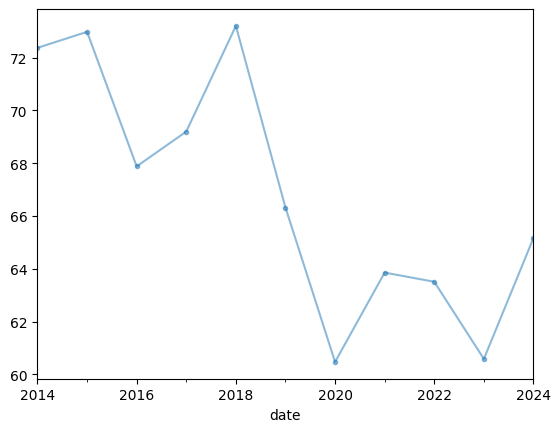

In [241]:
europe_y['air_quality_index'].plot(marker='.', alpha=0.5, linestyle='-') # plotting the data over the years

we can see that alot of our observations that we saw before are more apparent in this graph:
1) the pollution index being mostly in the moderate zone
2) the rise of air pollution in 2017-2018 due to forest fires and heat waves
3) the decrease of air pollution in 2020 due to lockdown
4) we can see that in 2023 we had a major decrease in the air quality index, ie improvement in the air quality this might be due to the fact that Europe started implementing strickter laws and regulations regarding the environment. Also, they started to shift towards greener energy sources, and greener modes of transportations!

Now, let us see if we have any trends in the months:

One hypthesis that is usually around is that air pollution increases in the summer and decreases in the winter, let us see what we can observe and if this is true!

In [242]:
monthly_aqi = europe.groupby(europe.index.month).mean() # doing aggregations month wise over all the years

<Axes: xlabel='date'>

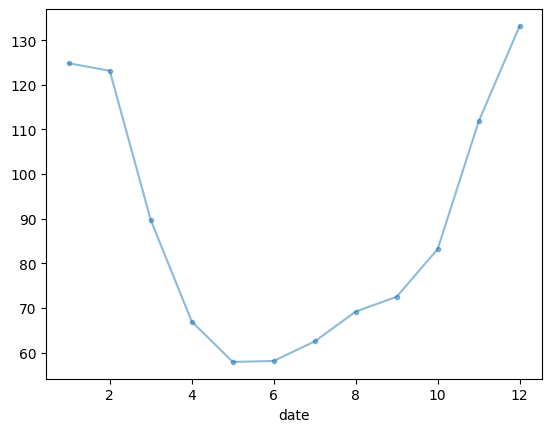

In [257]:
monthly_aqi['air_quality_index'].plot(marker='.', alpha=0.5, linestyle='-') # plotting the values

we can see that the opposite of our hypothesis is what is true! pollution decreases around spring/summer and increases around autumn/winter.

this might be due to many factors:
1) people use alot of heating elements that require more energy to fuel up/ may be done using elements that cause pollution like coal/wood etc..
2) the fact that in the winter the pollutant get trapped near the ground hwich prevents the pollutant from dispresing into the atmosphere but in the summer there is more wind and the warmer weather helps with dispersing the pollutants making them no accumulate. 

Now, let us smooth the data abit so we can see if everything matches up!

In [244]:
rolling = europe['air_quality_index'].rolling(window=4).mean() # using the rolling average to smooth out our original data!
rolling

date
2014-06          NaN
2014-07          NaN
2014-08          NaN
2014-09    60.416580
2014-10    65.877161
             ...    
2024-02    64.423868
2024-03    68.947296
2024-04    67.002881
2024-05    62.865020
2024-06    63.012693
Freq: M, Name: air_quality_index, Length: 121, dtype: float64

<Axes: xlabel='date'>

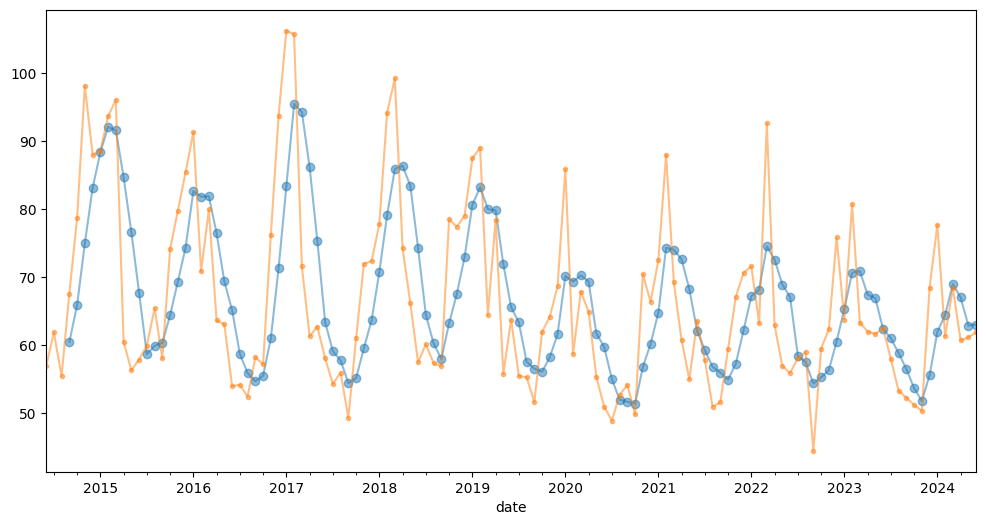

In [245]:
plt.figure(figsize=(12, 6))
rolling.plot(marker='o', alpha=0.5, linestyle='-')
europe['air_quality_index'].plot(marker='.', alpha=0.5, linestyle='-')

after smoothing out our original data on the year-month level, we can clearly see all the trends we have seen before:
1) how the index falls in the moderate range
2) how the peak pollution was around 2017
3) how the least pollution was around 2020
4) how pollution have been decreasing over the years and how low it has been in 2023!
5) how pollution increases in the winter and decreases in the summer! (the waves peak near the winter and get lower near the summer!)

##### Forecasting:

We can try to predict how the AQI will be in the future few months and see if we need to be worried or if all out efforts to minimize air pollution are actually helping out! to do this we can try forcasting.

I will be using auto_arima from pmdarima to forecast the values with seasonality turned on.

auto_arima is a model that utilizes ARIMA -autoregressive integrated moving average- a model used in statistics and econometrics to measure events that happen over a period of time. And with seasonality on it will be SARIMA - Seasonal AutoRegressive Integrated Moving Average- an extension of ARIMA that can account for seasonal patterns in the data.

In [277]:
europe_test = europe.loc[:'2021']

i will be testing the model out over a period of 6 months and 12 months to see which period better accounts for the trends to then use it to predict how the aqi will be in the next 24 months!

**6 MONTHS:**

In [321]:
import pmdarima as pm
model = pm.auto_arima(europe_test['air_quality_index'],
                      start_p=1, max_p=7,  # Allow for more AR terms
                      start_q=1, max_q=7,  # Allow for more MA terms
                      seasonal=True, m=6,  # Monthly data with yearly seasonality
                      start_P=1, max_P=4,  # Allow for more seasonal AR terms
                      start_Q=1, max_Q=4,  # Allow for more seasonal MA terms
                      d=0,  # Try with no differencing first
                      D=0,  # Try with no seasonal differencing
                      trace=True,  # Show model selection process
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[6] intercept   : AIC=681.396, Time=8.34 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=745.624, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=683.677, Time=1.87 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=701.110, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=1032.251, Time=0.01 sec
 ARIMA(1,0,1)(0,0,1)[6] intercept   : AIC=688.065, Time=0.27 sec
 ARIMA(1,0,1)(1,0,0)[6] intercept   : AIC=685.592, Time=0.41 sec
 ARIMA(1,0,1)(2,0,1)[6] intercept   : AIC=675.609, Time=2.54 sec
 ARIMA(1,0,1)(2,0,0)[6] intercept   : AIC=685.074, Time=0.39 sec
 ARIMA(1,0,1)(3,0,1)[6] intercept   : AIC=683.461, Time=1.10 sec
 ARIMA(1,0,1)(2,0,2)[6] intercept   : AIC=676.059, Time=2.73 sec
 ARIMA(1,0,1)(1,0,2)[6] intercept   : AIC=675.637, Time=0.66 sec
 ARIMA(1,0,1)(3,0,0)[6] intercept   : AIC=683.887, Time=1.01 sec
 ARIMA(1,0,1)(3,0,2)[6] intercept   : AIC=678.577, Time=8.35 sec
 ARIMA(0,0,1)(2,0,1)[6] intercept   : AIC=683.

In [323]:
forecast = model.predict(n_periods=24)
print(forecast)

2022-01    77.274781
2022-02    78.340902
2022-03    75.438848
2022-04    67.677114
2022-05    59.615941
2022-06    58.754342
2022-07    54.056049
2022-08    53.938462
2022-09    57.585414
2022-10    65.918757
2022-11    74.427524
2022-12    75.683854
2023-01    80.676706
2023-02    81.049053
2023-03    77.626558
2023-04    69.502352
2023-05    61.171130
2023-06    60.027194
2023-07    55.145941
2023-08    54.843520
2023-09    58.302042
2023-10    66.426156
2023-11    74.747520
2023-12    75.913378
Freq: M, dtype: float64


In [310]:
europe_tests = europe.loc[:'2021']

<Axes: xlabel='date'>

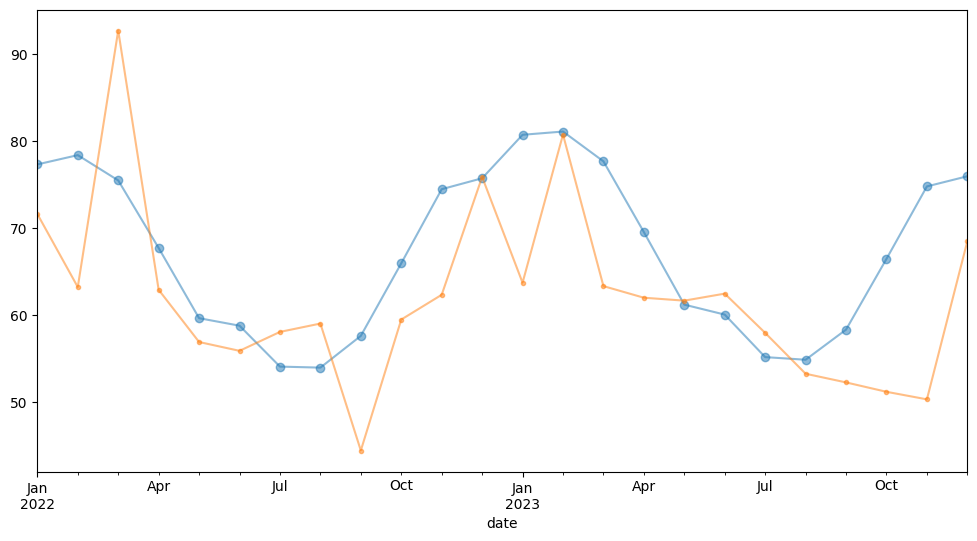

In [324]:
plt.figure(figsize=(12, 6))
forecast.plot(marker='o', alpha=0.5, linestyle='-')
europe['air_quality_index'].loc['2022':'2023'].plot(marker='.', alpha=0.5, linestyle='-')

In [327]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

actuals = europe['air_quality_index'].loc['2022':'2023']
# Calculate MAE, MAPE, RMSE
mae = mean_absolute_error(actuals, forecast)
rmse = mean_squared_error(actuals, forecast, squared=False)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - forecast) / actuals)) * 100

print(f"MAE: {mae}, RMSE: {rmse}, MAPE: {mape}%")

MAE: 7.879643445136736, RMSE: 10.188072100191311, MAPE: 13.291481205124475%


c:\Users\allab\OneDrive\Desktop\Final Project\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


the results are good, but can be improved upon!

**12 MONTHS:**

In [328]:
import pmdarima as pm
model = pm.auto_arima(europe_test['air_quality_index'],
                      start_p=1, max_p=7,  # Allow for more AR terms
                      start_q=1, max_q=7,  # Allow for more MA terms
                      seasonal=True, m=12,  # Monthly data with yearly seasonality
                      start_P=1, max_P=4,  # Allow for more seasonal AR terms
                      start_Q=1, max_Q=4,  # Allow for more seasonal MA terms
                      d=0,  # Try with no differencing first
                      D=0,  # Try with no seasonal differencing
                      trace=True,  # Show model selection process
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=9.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=745.624, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=690.481, Time=0.76 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=705.260, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1032.251, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=692.736, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=682.346, Time=2.19 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=680.397, Time=8.46 sec
 ARIMA(1,0,0)(4,0,0)[12] intercept   : AIC=inf, Time=10.60 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=683.391, Time=3.09 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=684.442, Time=5.27 sec
 ARIMA(1,0,0)(4,0,1)[12] intercept   : AIC=inf, Time=8.36 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=inf, Time=1.66 sec
 ARIMA(2,0,0)(3,0,0)[12] intercept   : AIC=682.065, Time=2.67 sec
 ARIMA(1,0,1)(3,0,0)[12] intercept   : AIC=682.

In [329]:
forecast = model.predict(n_periods=24)
print(forecast)

2022-01    79.123593
2022-02    73.140381
2022-03    67.111350
2022-04    68.844813
2022-05    59.126309
2022-06    60.983078
2022-07    57.407304
2022-08    57.669817
2022-09    57.241898
2022-10    59.644185
2022-11    67.604966
2022-12    67.972610
2023-01    75.512843
2023-02    72.363059
2023-03    68.212438
2023-04    65.000072
2023-05    59.434877
2023-06    61.172935
2023-07    58.379496
2023-08    57.293603
2023-09    57.835998
2023-10    59.437629
2023-11    68.303114
2023-12    68.356893
Freq: M, dtype: float64


<Axes: xlabel='date'>

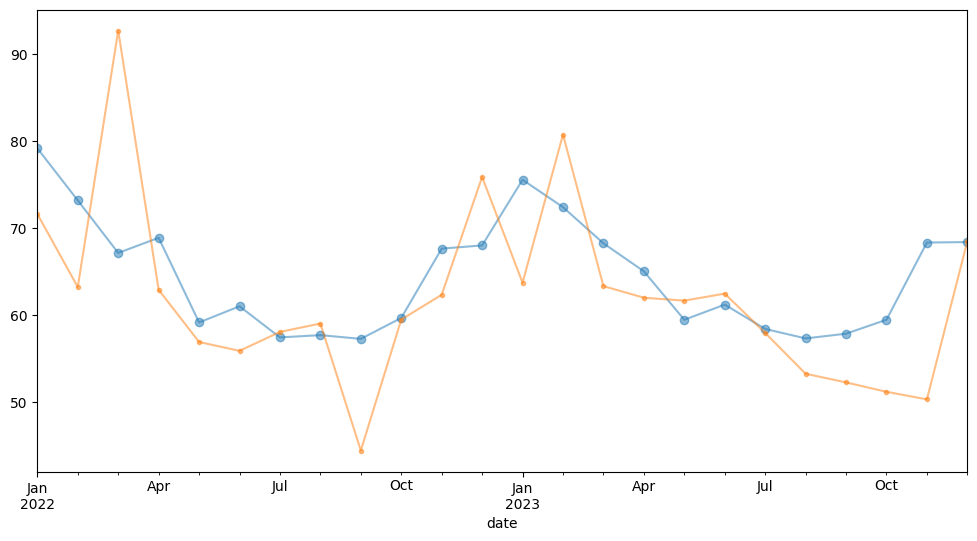

In [330]:
plt.figure(figsize=(12, 6))
forecast.plot(marker='o', alpha=0.5, linestyle='-')
europe['air_quality_index'].loc['2022':'2023'].plot(marker='.', alpha=0.5, linestyle='-')

In [331]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

actuals = europe['air_quality_index'].loc['2022':'2023']
# Calculate MAE, MAPE, RMSE
mae = mean_absolute_error(actuals, forecast)
rmse = mean_squared_error(actuals, forecast, squared=False)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - forecast) / actuals)) * 100

print(f"MAE: {mae}, RMSE: {rmse}, MAPE: {mape}%")

MAE: 6.35655467504478, RMSE: 8.711820195289697, MAPE: 10.259757471115426%


c:\Users\allab\OneDrive\Desktop\Final Project\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


relatively better results! 
I will be using a period of 12 months to predict the next 24 months!

**The Predictions:**

In [336]:
import pmdarima as pm
model = pm.auto_arima(europe['air_quality_index'],
                      start_p=1, max_p=7,  # Allow for more AR terms
                      start_q=1, max_q=7,  # Allow for more MA terms
                      seasonal=True, m=12,  # Monthly data with yearly seasonality
                      start_P=1, max_P=4,  # Allow for more seasonal AR terms
                      start_Q=1, max_Q=4,  # Allow for more seasonal MA terms
                      d=0,  # Try with no differencing first
                      D=0,  # Try with no seasonal differencing
                      trace=True,  # Show model selection process
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=5.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=976.105, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=916.080, Time=0.73 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=933.256, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1366.725, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=916.741, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=897.239, Time=1.85 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=898.508, Time=6.45 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=899.065, Time=4.20 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=901.025, Time=0.79 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=898.608, Time=8.18 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=909.455, Time=1.92 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=899.144, Time=8.93 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=899.148, Time=5.10 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept  

In [337]:
forecast = model.predict(n_periods=24)
print(forecast)

2024-07    61.560788
2024-08    60.931832
2024-09    54.325913
2024-10    60.653831
2024-11    61.717554
2024-12    71.107309
2025-01    67.585226
2025-02    71.844642
2025-03    65.626821
2025-04    63.562316
2025-05    63.503033
2025-06    63.992377
2025-07    61.970749
2025-08    59.805130
2025-09    58.099959
2025-10    58.847206
2025-11    58.674049
2025-12    68.398115
2026-01    71.744351
2026-02    65.402222
2026-03    67.314693
2026-04    63.555758
2026-05    63.742856
2026-06    64.149255
Freq: M, dtype: float64


<Axes: xlabel='date'>

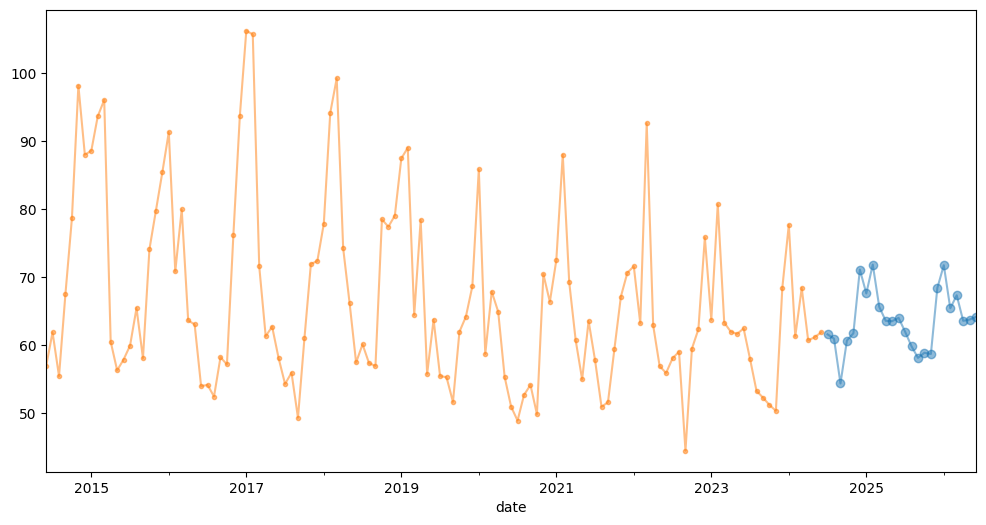

In [338]:
plt.figure(figsize=(12, 6))
forecast.plot(marker='o', alpha=0.5, linestyle='-')
europe['air_quality_index'].plot(marker='.', alpha=0.5, linestyle='-')

as we can see, the prediction follows the tred of our data and it seems like the laws are regulations will be of help but we need to take some more action to make the air quality be good and not moderate!

#### Across the Countries:

first i will try out how to aggregate the data country wise!

In [339]:
# taking germany as my example, and grouping by date then getting the mean!

germany = wh_df[wh_df["country_name"] == "Germany"][['date', 'air_quality_index']].groupby('date').agg({'air_quality_index' : 'mean'}).reset_index()
germany

date  air_quality_index
0    2014-06            56.4783
1    2014-07            57.2131
2    2014-08            45.8809
3    2014-09            73.9422
4    2014-10            76.4122
..       ...                ...
116  2024-02            39.7213
117  2024-03            61.1311
118  2024-04            55.0584
119  2024-05            56.1283
120  2024-06            55.5266

[121 rows x 2 columns]

applying the previous code on all the countries:

In [340]:
# now i got the list of the distinct countries that i have in my dataset and do the aggregation like before then store them inside a dictionary for easy access!

countries = wh_df.country_name.unique().tolist() # getting the unique countries

country_dfs = {}
for country in countries: # for each country do the same as we did for germany then store it in the dict as 'country' : 'dataframe'
    country_dfs[country] =  wh_df[wh_df["country_name"] == f"{country}"][['date', 'air_quality_index']].groupby('date').agg({'air_quality_index' : 'mean'})
    
country_dfs # making sure the code worked

{'Germany':          air_quality_index
 date                      
 2014-06            56.4783
 2014-07            57.2131
 2014-08            45.8809
 2014-09            73.9422
 2014-10            76.4122
 ...                    ...
 2024-02            39.7213
 2024-03            61.1311
 2024-04            55.0584
 2024-05            56.1283
 2024-06            55.5266
 
 [121 rows x 1 columns],
 'Czech Republic':          air_quality_index
 date                      
 2014-06            54.9758
 2014-07            67.9710
 2014-08            51.4226
 2014-09            85.2324
 2014-10           130.9450
 ...                    ...
 2024-02            53.7878
 2024-03            86.1496
 2024-04            60.4413
 2024-05            61.7020
 2024-06            61.3557
 
 [121 rows x 1 columns],
 'Greece':          air_quality_index
 date                      
 2014-06            75.7059
 2014-07            66.8402
 2014-08            76.2737
 2014-09            77.4950
 2014-10   

In [248]:
type(country_dfs['Germany']) # making sure that the value in the dict is a dataframe!

pandas.core.frame.DataFrame

now to plot the data of the countries!

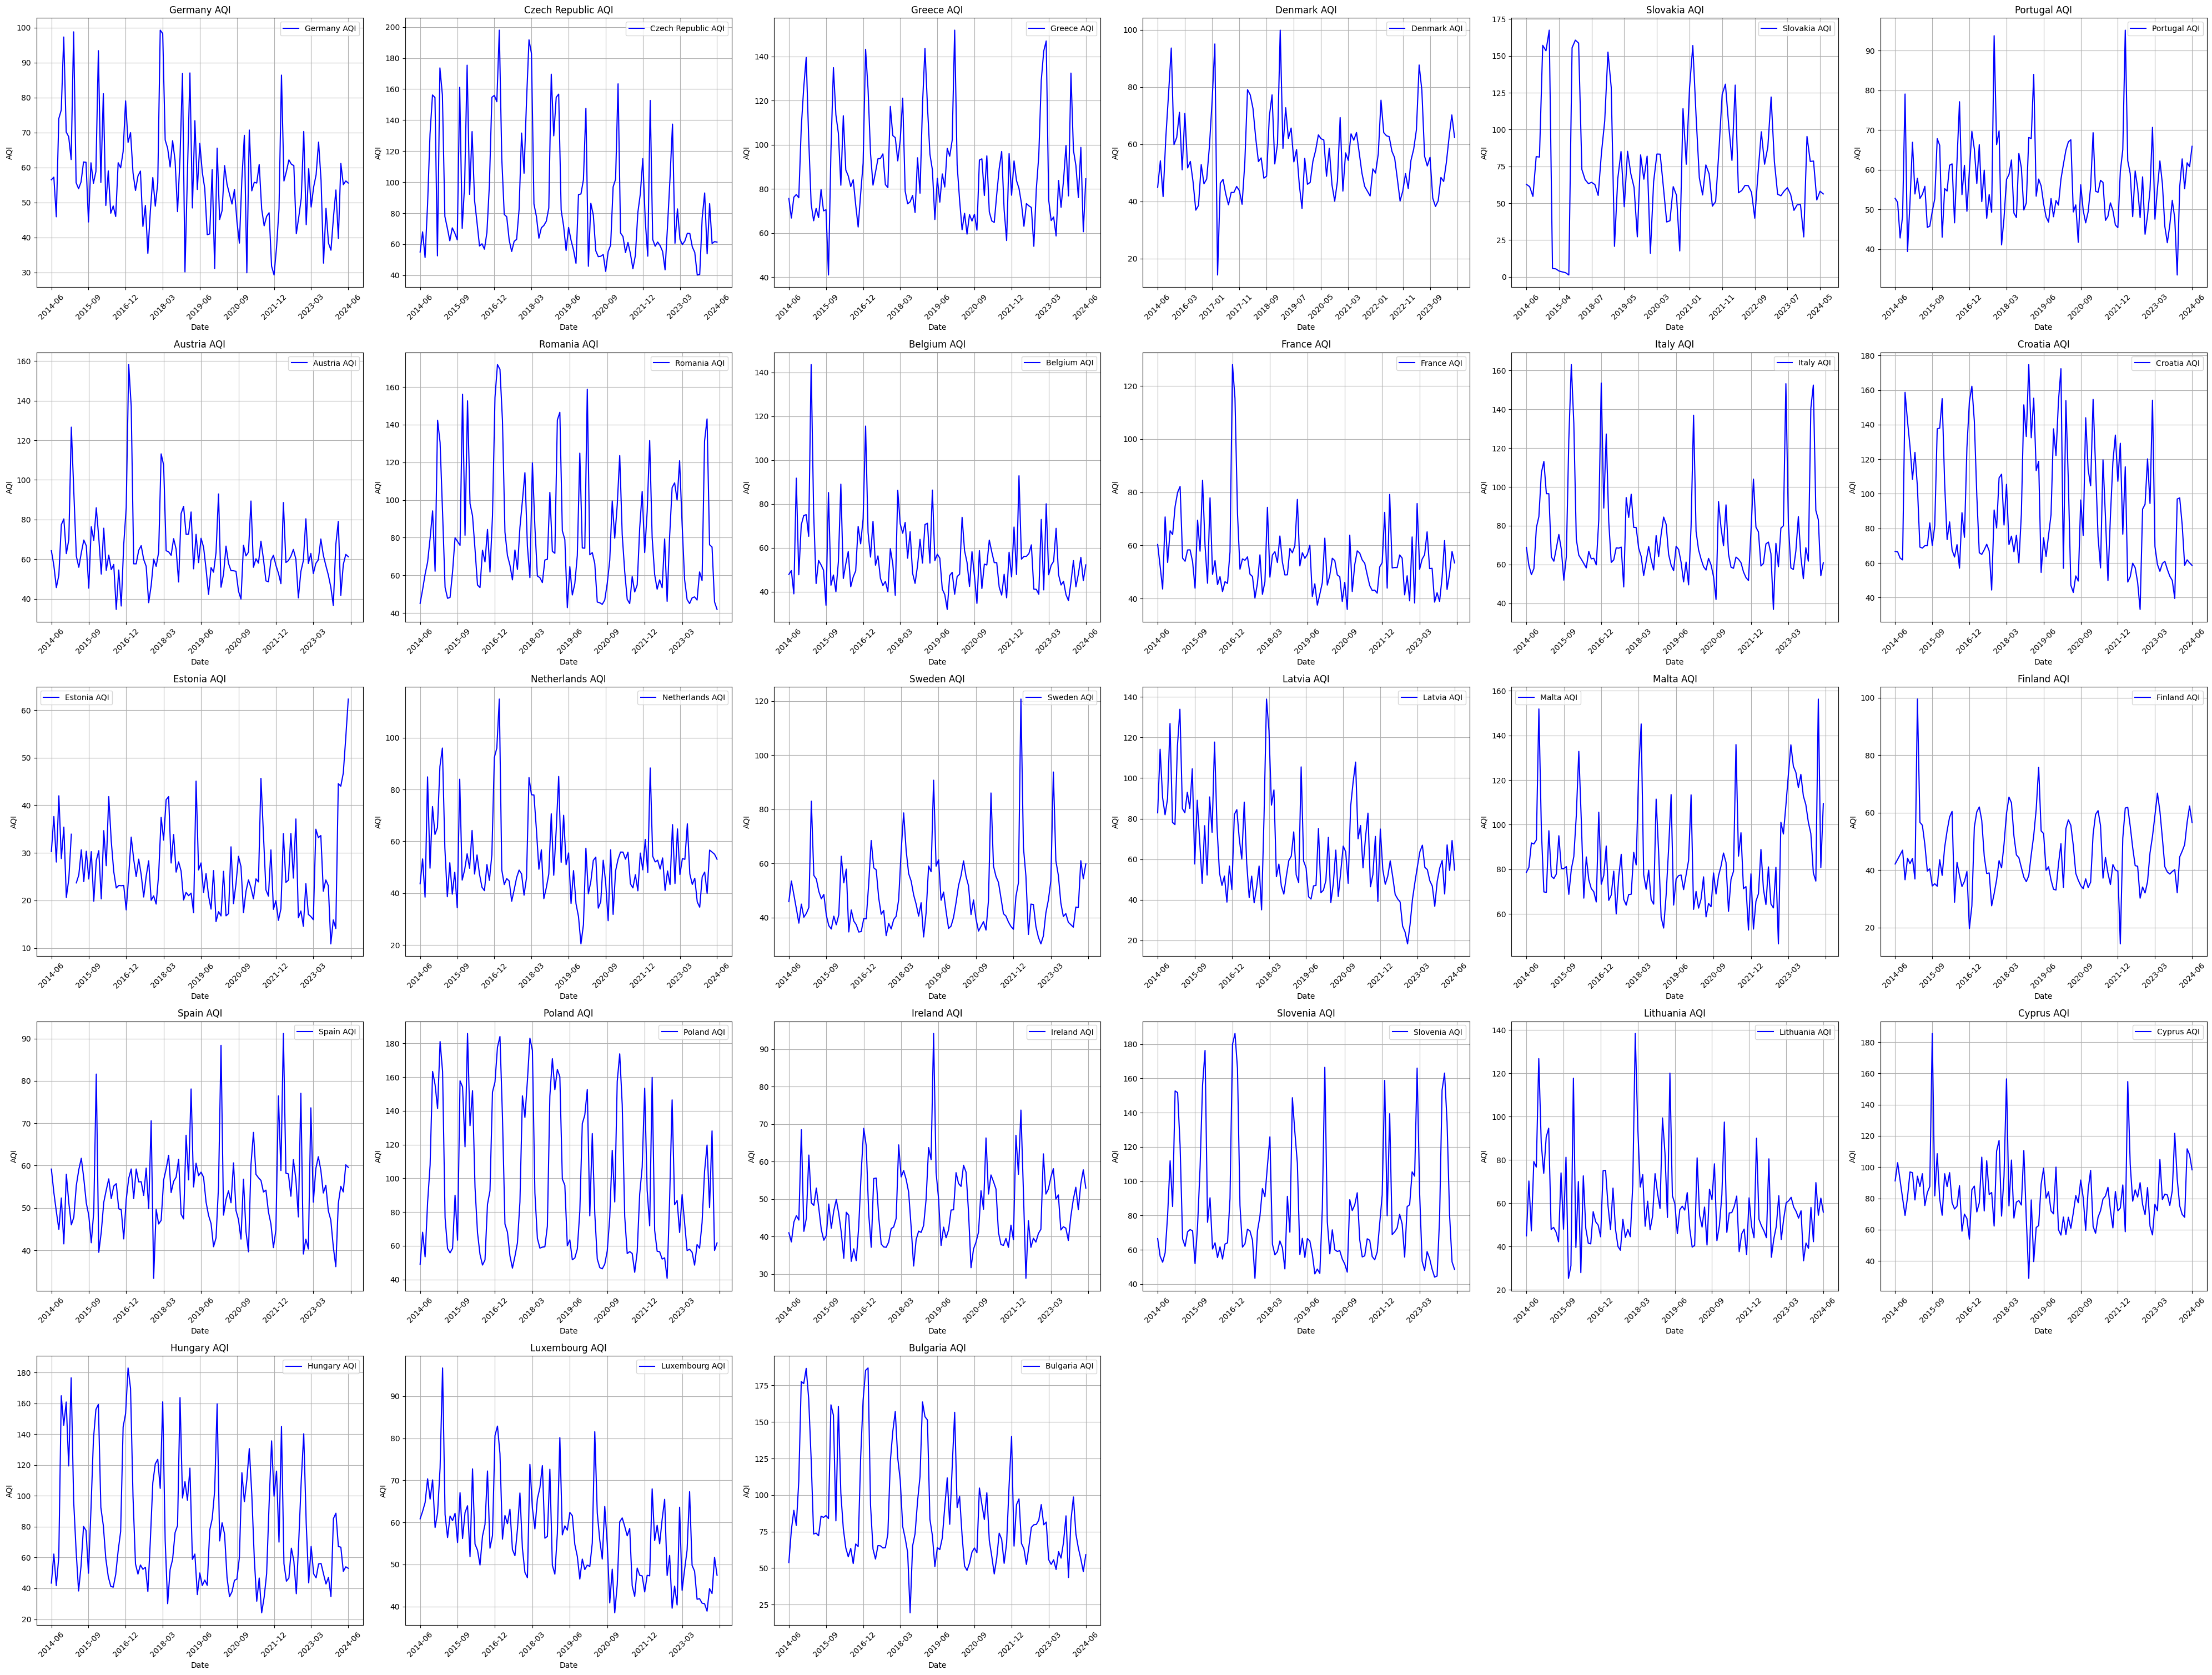

In [341]:
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(27, 6, figsize=(40, 6 * 27))

axs = axs.flatten()

for i, country in enumerate(countries):
    axs[i].plot(country_dfs[country].index, country_dfs[country]['air_quality_index'], label=f'{country} AQI', color='blue')
    axs[i].set_title(f'{country} AQI')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('AQI')
    axs[i].legend()
    axs[i].grid(True)
    axs[i].tick_params(axis='x', rotation=45)
    # Reduce the number of x-ticks by setting a maximum number of ticks
    axs[i].xaxis.set_major_locator(MaxNLocator(nbins=12)) 

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

we can see that generally all the countries' graphs follow the same pattern as the graph of europe, we can notice a few things:
1) Most countries have generally moderate air quality except for: Greece, Slovakia, Romania, Austria (around 2014-2016-2017), Belgium (around 2014 and 2017), France in 2017, Italy, Croatia, Sweden around 2021, Latvia pre 2022, Malta, Poland, Slovenia, Lithuania around (2016->2018), Cyprus around (2014-2017-2021), Hungary, Bulgaria pre 2021!
2) all countries had reduced air pollution around 2020 due to lock down! and most of them have less ai pollution after!
3) alot of the countries had peak air pollutiona around 2016-2017

Some reasons about the hightened air pollution in some of the countries:
1) Slovakia, Poland, and Hungary: they share borders and pollution from Poland's Coal production may have been drifitng into Slovakia and Hungary
2) Greece, Croatia, Italy, and Cyprus: face alot of wildfires 
3) Poland, Bulgaria, Hungary, Slovakia, and Romania: Rely on Coal and fossil fuel for power until recently.
4) Austria, Italy, Romania: can experience air stagnation in valleys, leading to poor air dispersion.

and alot of varying reasons from power supply to natural geography to industrliaztion and urbanization

now let us see the Index average over the years!

In [342]:
countries = wh_df.country_name.unique().tolist()

country_dfs_y = {}
for country in countries:
    df =  wh_df[wh_df["country_name"] == f"{country}"][['date', 'air_quality_index']].set_index('date')
    df.index = pd.PeriodIndex(df.index, freq='M')
    country_dfs_y[country] = pd.DataFrame(df['air_quality_index'].resample('Y').mean())


country_dfs_y

C:\Users\allab\AppData\Local\Temp\ipykernel_19624\2537582359.py:7: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  country_dfs_y[country] = pd.DataFrame(df['air_quality_index'].resample('Y').mean())
C:\Users\allab\AppData\Local\Temp\ipykernel_19624\2537582359.py:7: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  country_dfs_y[country] = pd.DataFrame(df['air_quality_index'].resample('Y').mean())
C:\Users\allab\AppData\Local\Temp\ipykernel_19624\2537582359.py:7: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  country_dfs_y[country] = pd.DataFrame(df['air_quality_index'].resample('Y').mean())
C:\Users\allab\AppData\Local\Temp\ipykernel_19624\2537582359.py:7: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  country_dfs_

{'Germany':       air_quality_index
 date                   
 2014          68.187771
 2015          61.512125
 2016          62.068067
 2017          53.880783
 2018          66.940225
 2019          56.038508
 2020          53.180283
 2021          47.614625
 2022          56.536692
 2023          49.078492
 2024          53.517733,
 'Czech Republic':       air_quality_index
 date                   
 2014         100.182686
 2015          93.632775
 2016         101.237775
 2017          98.723292
 2018         112.901867
 2019          87.004242
 2020          68.814817
 2021          79.333175
 2022          77.746717
 2023          61.093958
 2024          69.413300,
 'Greece':       air_quality_index
 date                   
 2014          86.588229
 2015          84.452908
 2016          88.212875
 2017         100.127742
 2018          90.205183
 2019          94.499492
 2020          79.866325
 2021          78.020725
 2022          80.743975
 2023          92.084075
 2024    

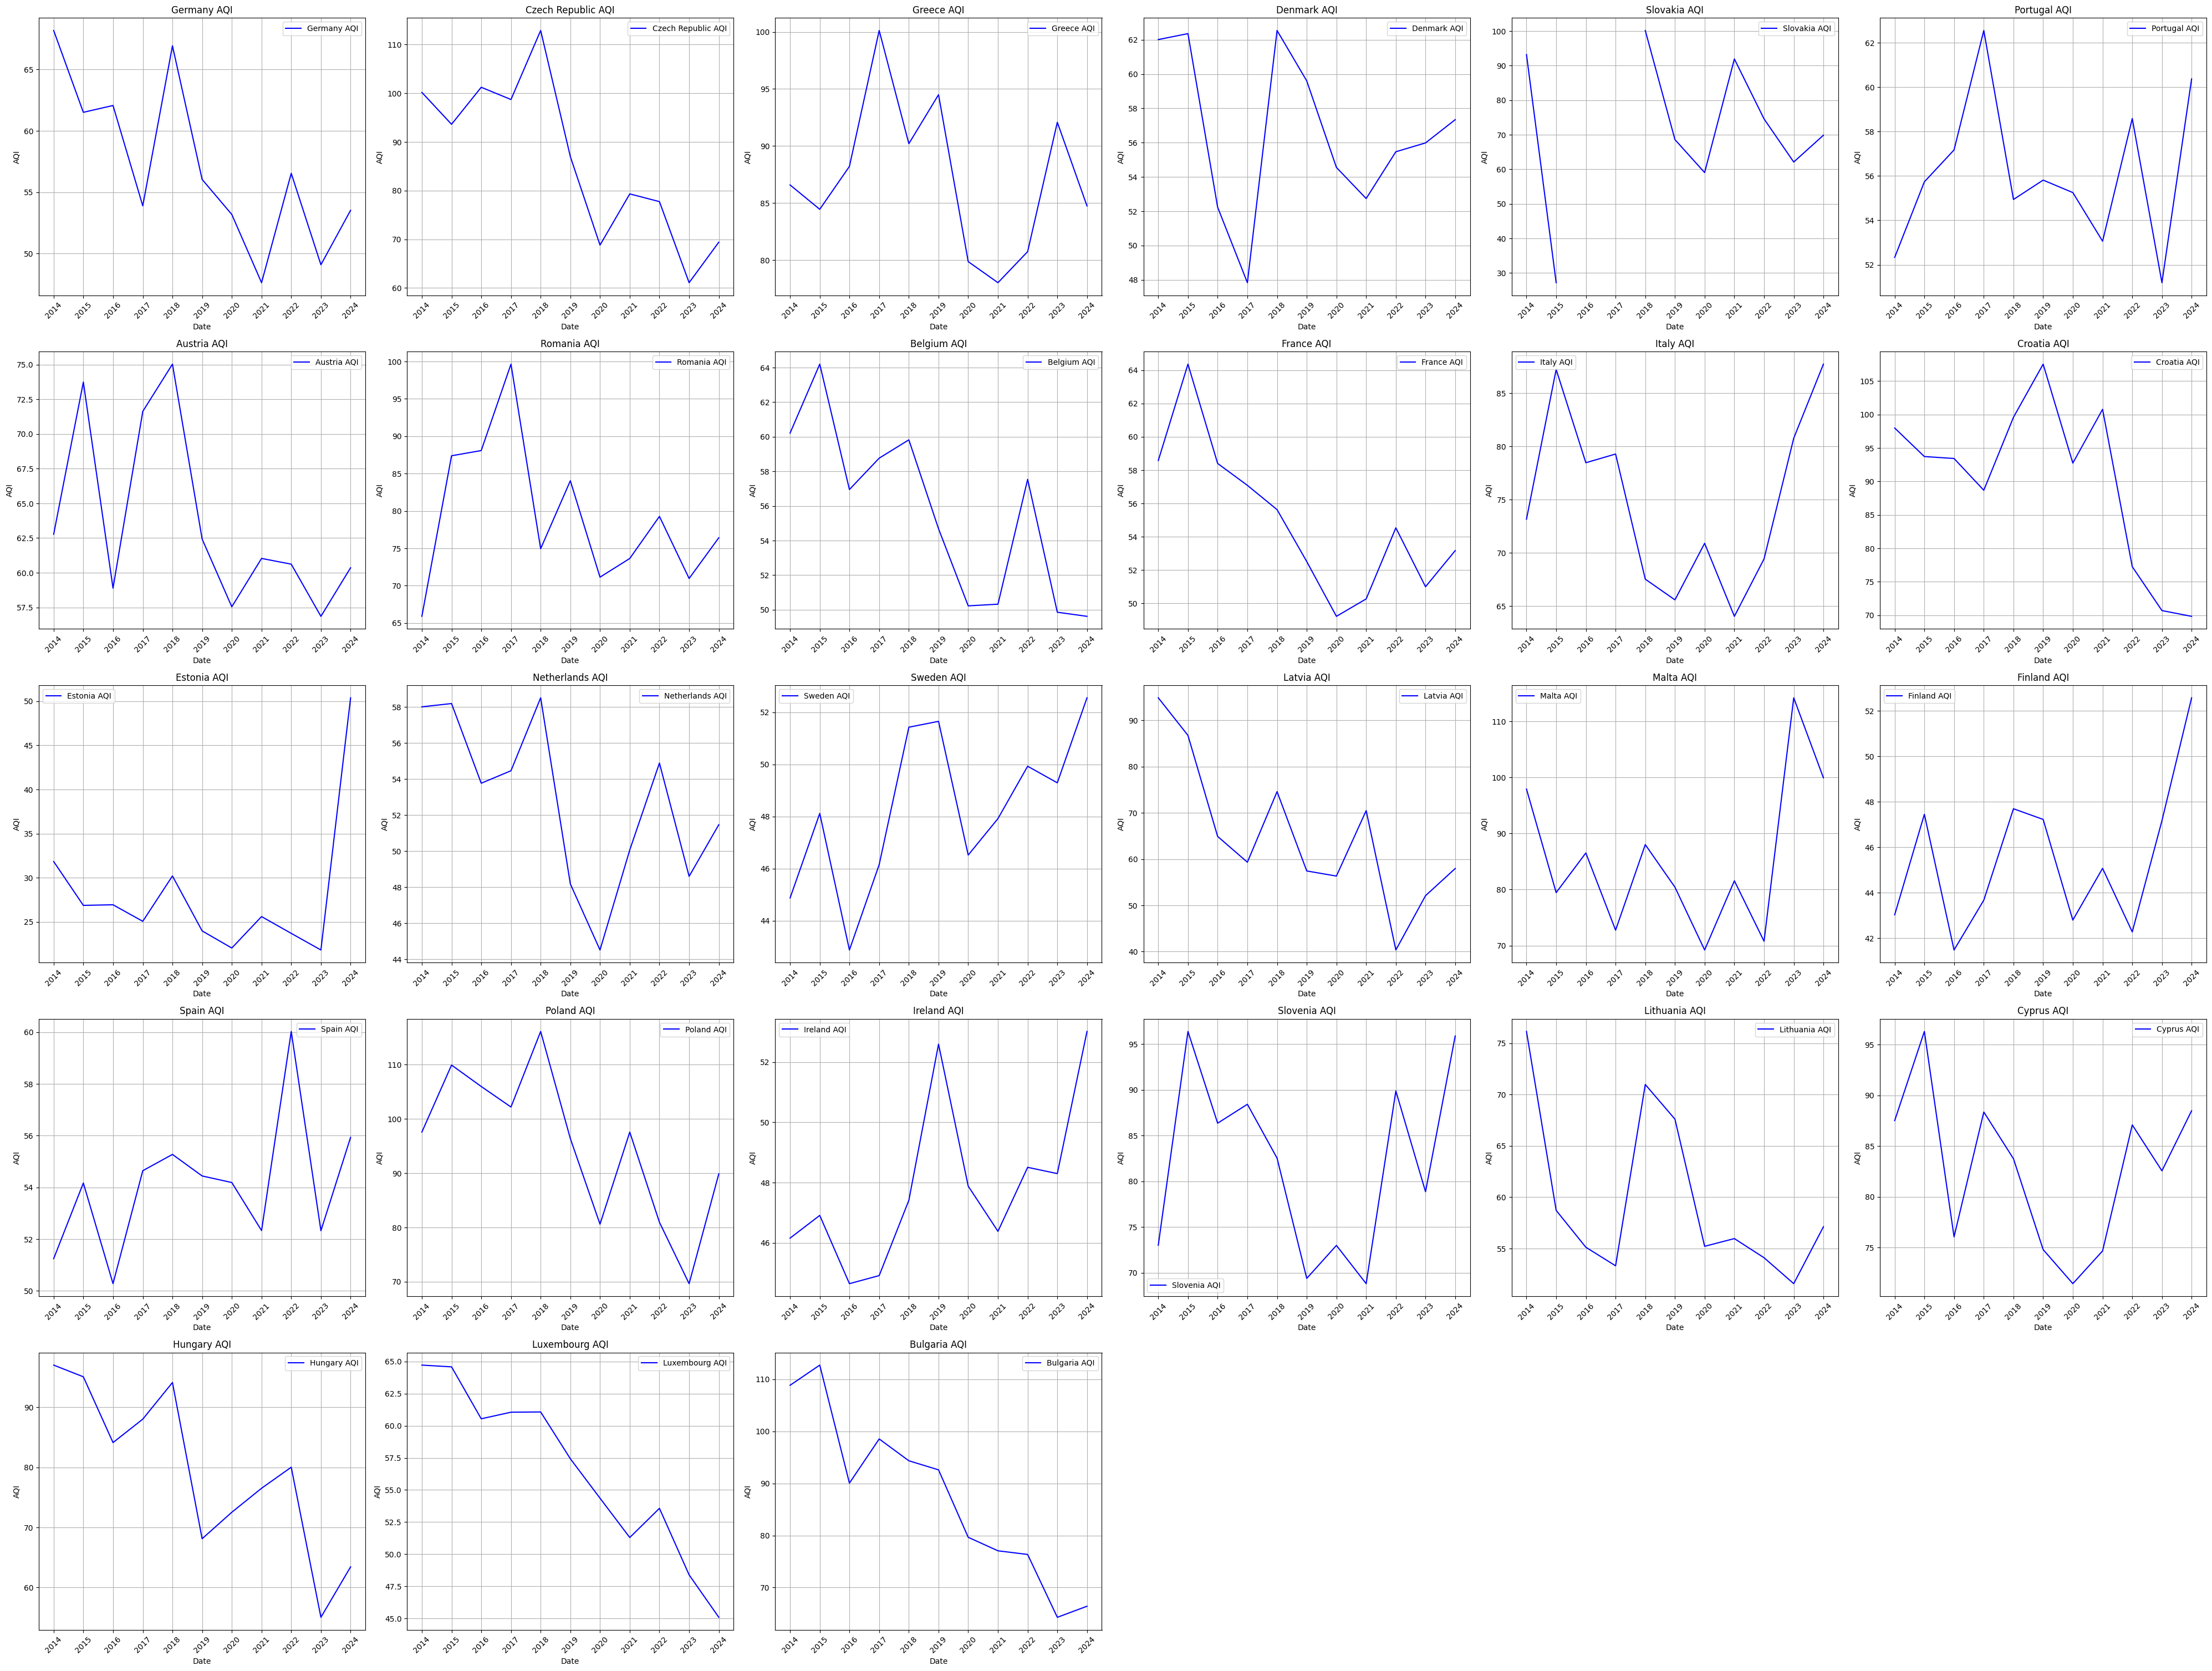

In [343]:
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(27, 6, figsize=(40, 6 * 27))

axs = axs.flatten()

for i, country in enumerate(countries):
    axs[i].plot(country_dfs_y[country].index.to_timestamp(), country_dfs_y[country]['air_quality_index'], label=f'{country} AQI', color='blue')
    axs[i].set_title(f'{country} AQI')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('AQI')
    axs[i].legend()
    axs[i].grid(True)
    axs[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

we can see that aggregating over the years yield the same analysis, what we can also notice is that some countries had a surge in air pollution around 2024 like: Portugal, Italy, Estonia, Sweden, Malta, Finland, Ireland, and Slovenia
Portugal and Italy face severe wildfires this year so this might be a contruting factor. There is also a power crisis in Europe so some of these countires may have started relying on coal, natural gas, and other fossil fuels more which does generate more pollution.
Also with alof of the heat waves, in countries like Portugal, Italy, Malta, and Finland if there was already a build up of pullion hight heats make it worse!

Now we can check the trends in the months and how pollution might change with the season

In [347]:
countries = wh_df.country_name.unique().tolist()

country_dfs_m = {}
for country in countries:
    df =  wh_df[wh_df["country_name"] == f"{country}"][['date', 'air_quality_index']].set_index('date')
    df.index = pd.PeriodIndex(df.index, freq='M')
    monthly_aqi = df.groupby(df.index.month).mean() 
    country_dfs_m[country] = monthly_aqi


country_dfs_m


{'Germany':       air_quality_index
 date                   
 1             57.284940
 2             63.730240
 3             68.206420
 4             58.110170
 5             57.317450
 6             58.477155
 7             55.193850
 8             50.841630
 9             48.308070
 10            51.851060
 11            59.657110
 12            53.236030,
 'Czech Republic':       air_quality_index
 date                   
 1            116.457010
 2            121.017530
 3            112.472640
 4             72.998120
 5             64.856650
 6             61.471073
 7             61.915370
 8             57.669660
 9             59.491880
 10            89.601960
 11           106.987090
 12           117.276110,
 'Greece':       air_quality_index
 date                   
 1            120.528900
 2            105.119900
 3             82.489330
 4             83.544530
 5             71.753830
 6             75.840336
 7             78.362310
 8             79.622710
 9       

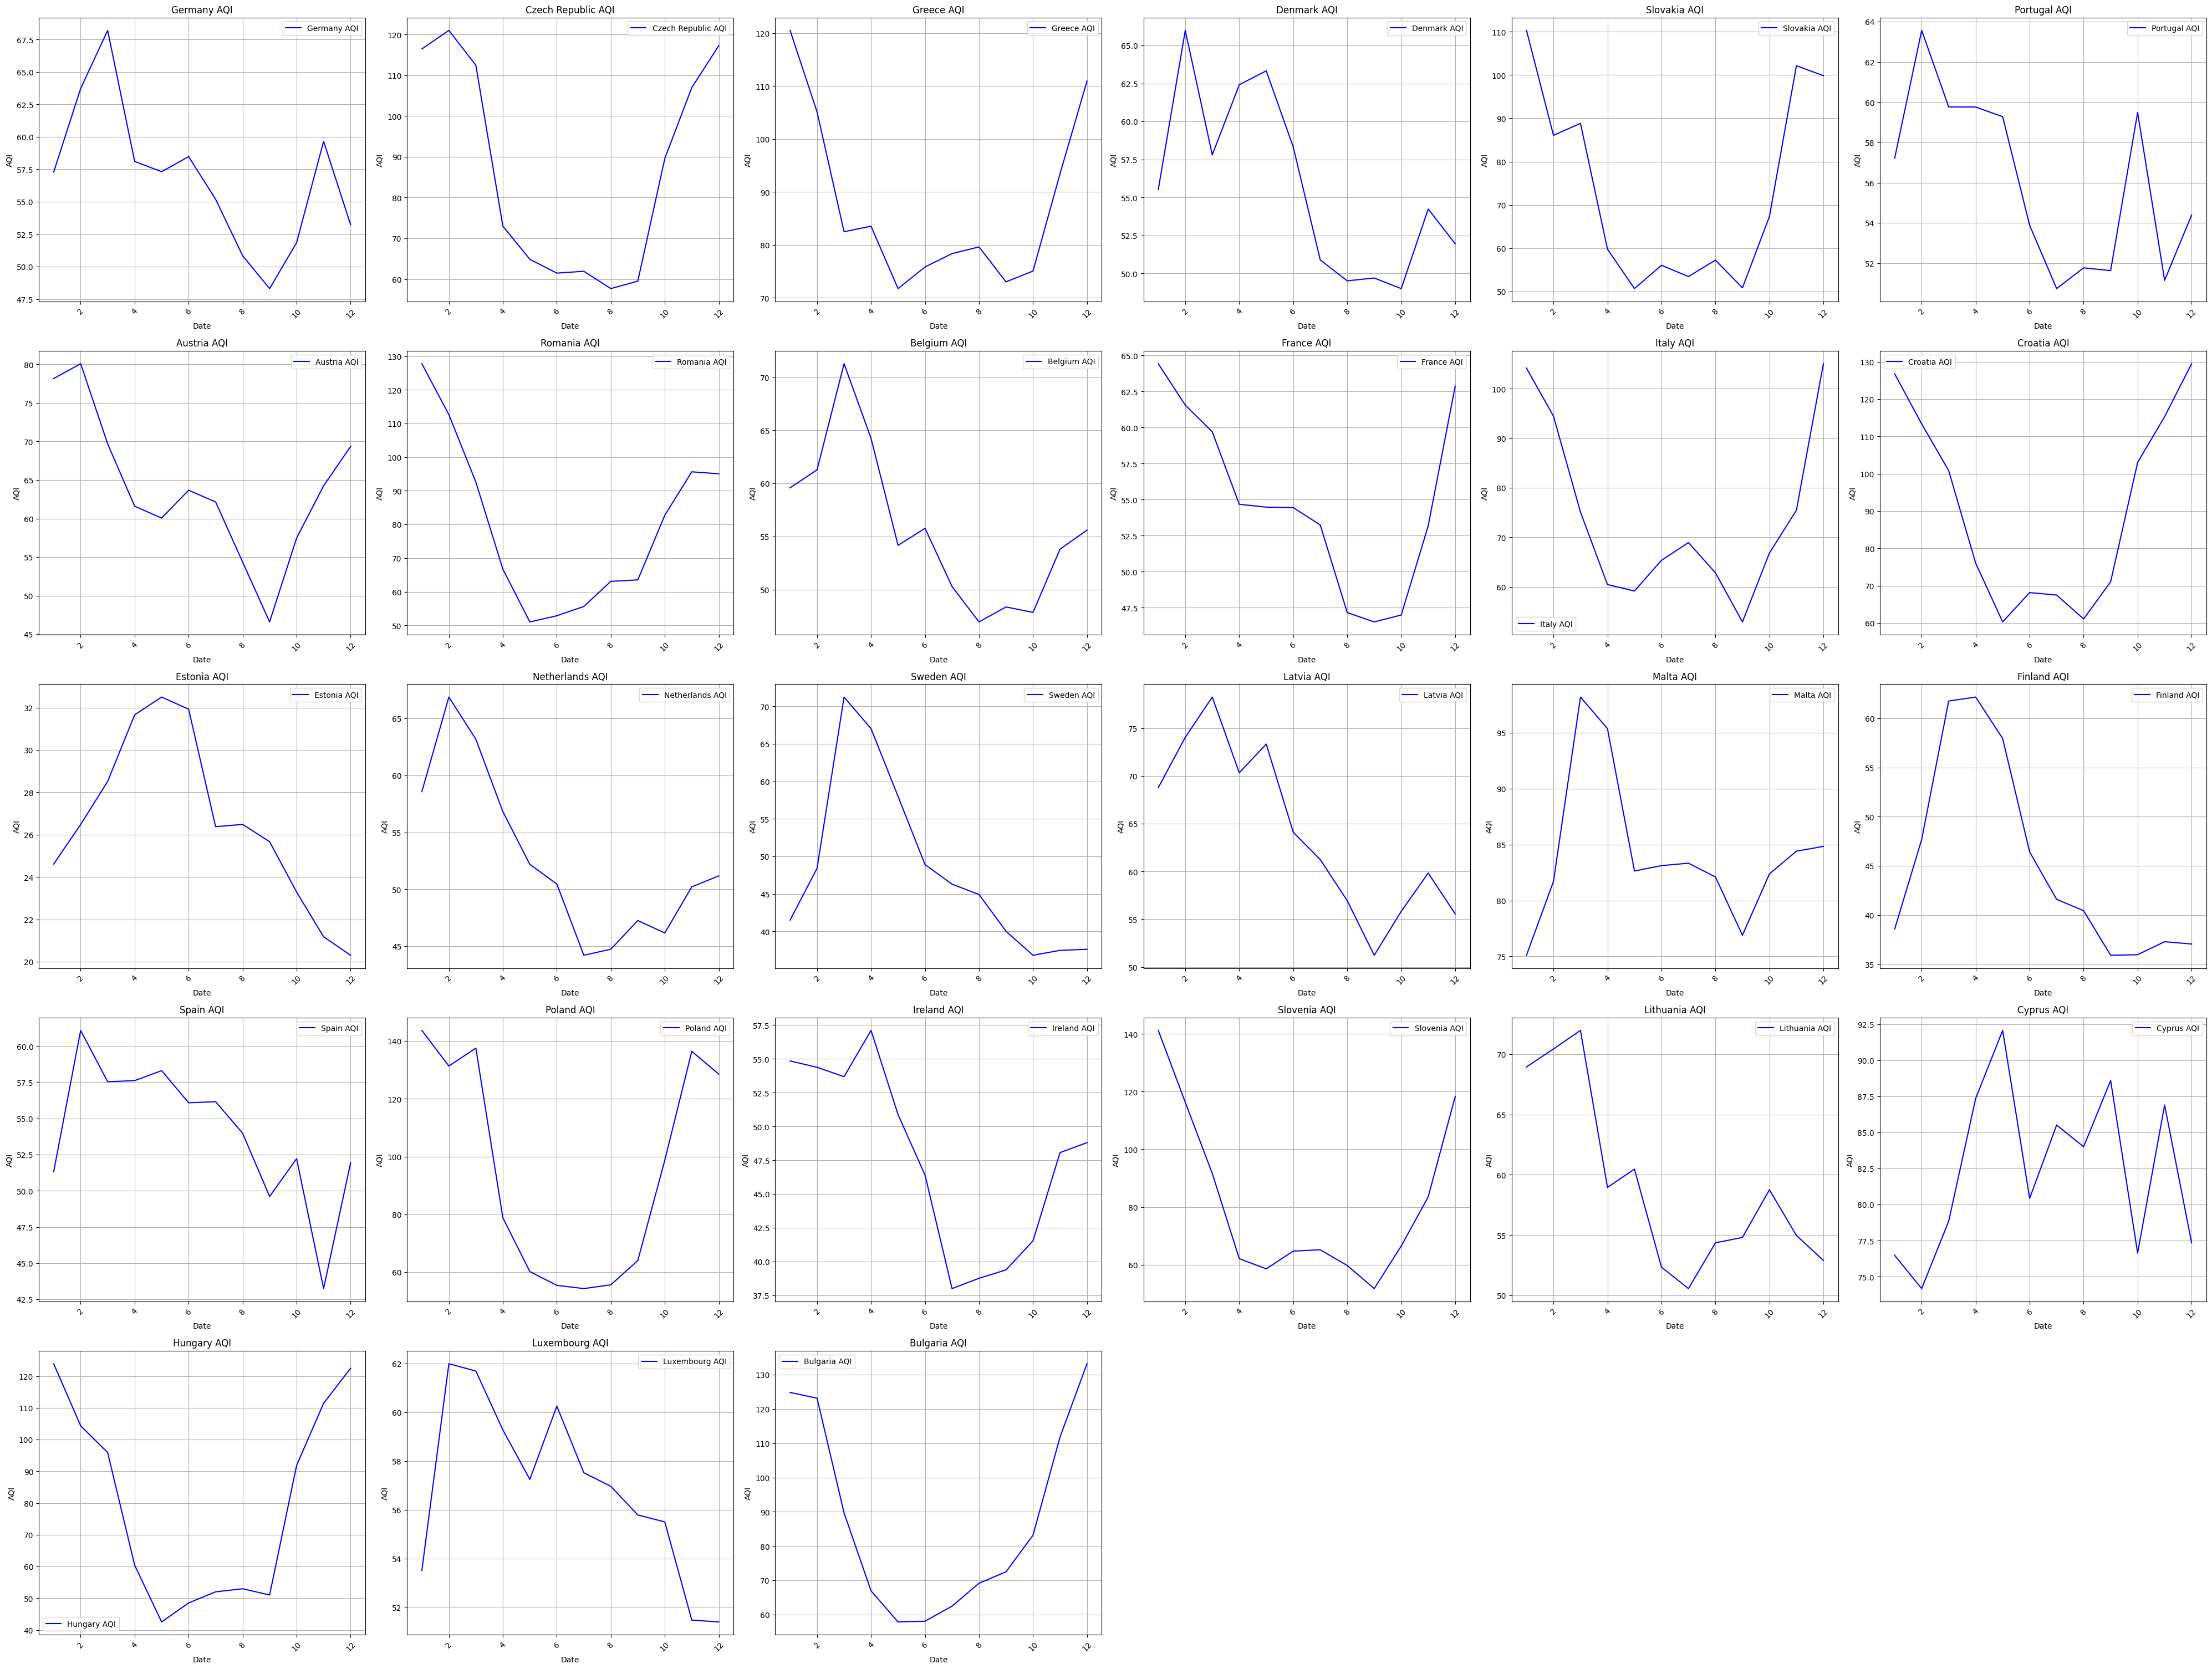

In [255]:
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(27, 6, figsize=(40, 6 * 27))

axs = axs.flatten()

for i, country in enumerate(countries):
    axs[i].plot(country_dfs_m[country].index, country_dfs_m[country]['air_quality_index'], label=f'{country} AQI', color='blue')
    axs[i].set_title(f'{country} AQI')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('AQI')
    axs[i].legend()
    axs[i].grid(True)
    axs[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

just like with the general europe AQI, almost all the countries have a rise in pollution in the winter times and a decrease around the summer times!

now lets us try smoothing out the data:

In [354]:
countries = wh_df.country_name.unique().tolist()

country_dfs_r = {}
for country in countries:
    df =  wh_df[wh_df["country_name"] == f"{country}"][['date', 'air_quality_index']].set_index('date')
    df['rolling_average'] = df['air_quality_index'].rolling(window=4).mean()
    country_dfs_r[country] = df

country_dfs_r


{'Germany':          air_quality_index  rolling_average
 date                                       
 2016-04            49.1060              NaN
 2016-12            79.0188              NaN
 2021-10            47.0315              NaN
 2021-08            43.2954        54.612925
 2019-11            59.3676        57.178325
 ...                    ...              ...
 2023-09            48.2924        48.172100
 2024-04            55.0584        46.548775
 2023-12            45.6229        47.173750
 2024-05            56.1283        51.275500
 2024-06            55.5266        53.084050
 
 [121 rows x 2 columns],
 'Czech Republic':          air_quality_index  rolling_average
 date                                       
 2023-04            59.7973              NaN
 2022-06            61.4011              NaN
 2016-04            88.3239              NaN
 2017-02           197.9570       101.869825
 2019-01           154.6660       125.587000
 ...                    ...              ...

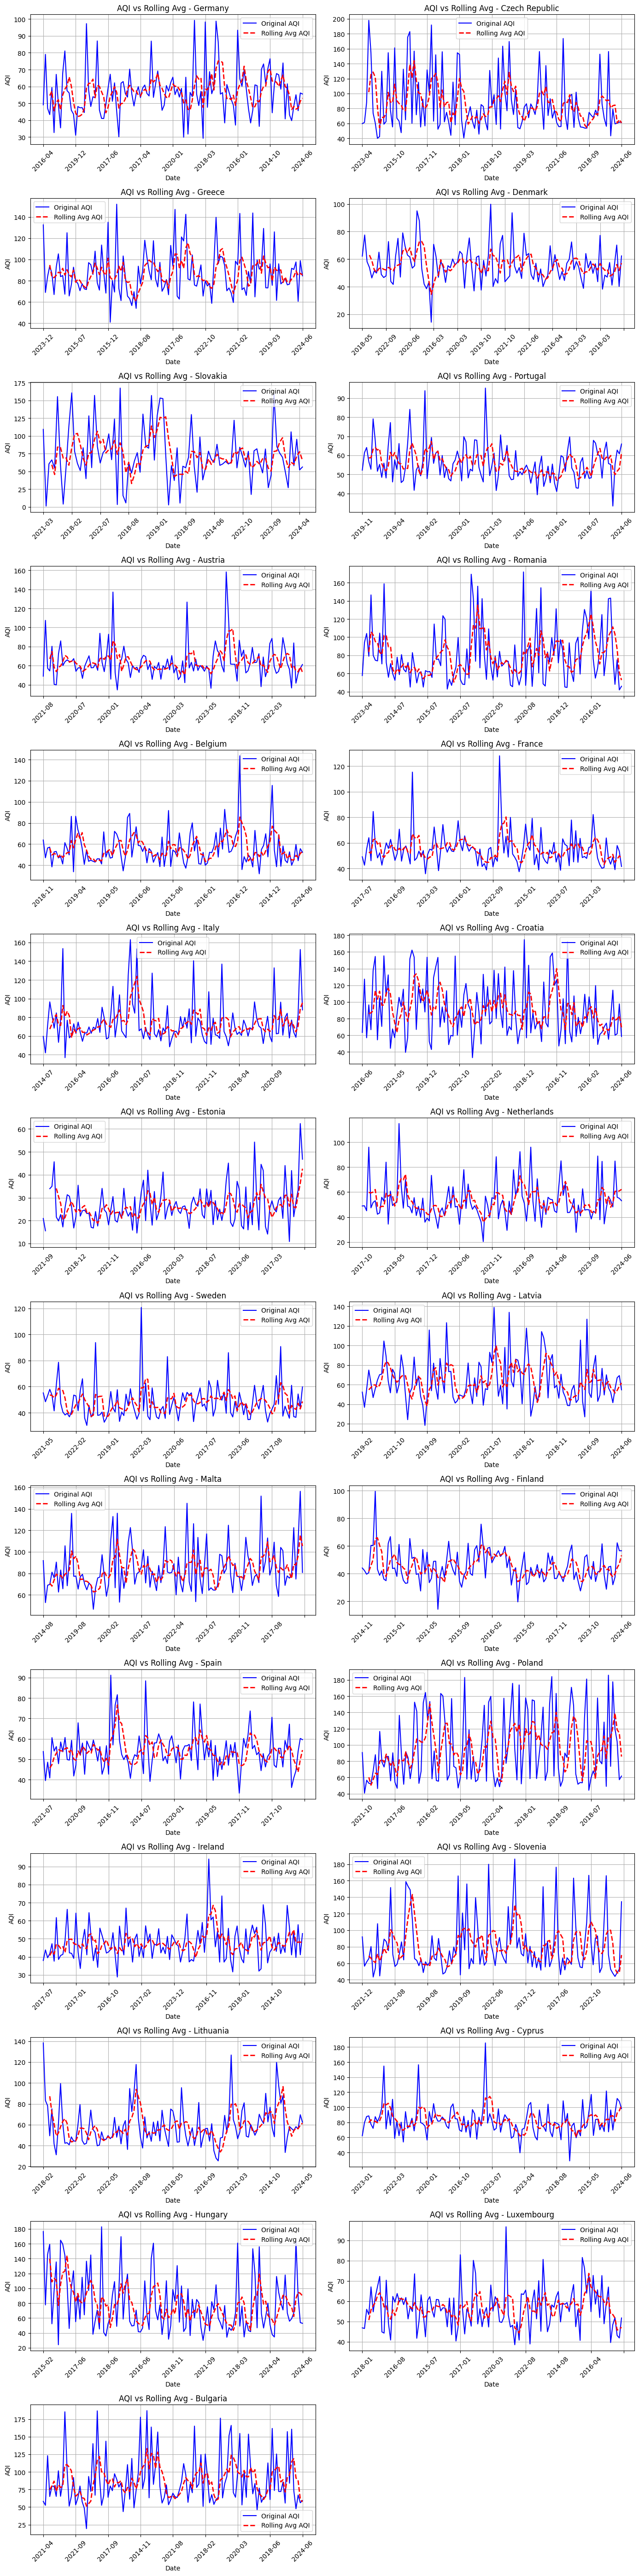

In [358]:
import matplotlib.pyplot as plt

num_countries = len(country_dfs_r)

cols = 2
rows = (num_countries // cols) + (num_countries % cols > 0)  

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 4))  

axes = axes.flatten()

for i, (country, df) in enumerate(country_dfs_r.items()):
    ax = axes[i] 
    ax.plot(df.index, df['air_quality_index'], label='Original AQI', color='blue', linewidth=1.5)
    ax.plot(df.index, df['rolling_average'], label='Rolling Avg AQI', color='red', linestyle='--', linewidth=2)

    ax.set_title(f'AQI vs Rolling Avg - {country}')
    ax.set_xlabel('Date')
    ax.set_ylabel('AQI')

    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=12))

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

we can see that we have the same trends and spike as before however it is much harder to see when we have unlhealthy levels of air pollution using the rolling average alone, this might be due to the fact at how much the pollution is alternating in the countries during seasons and certain events like wildfires, heat waves, and more non green energy power source reliance!